In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import joblib

# Notebook criado com o intuito de modelar dados e utiliza-los para treinar modelos de aprendizado de máquina.

In [ ]:
df = pd.read_csv('../data_processed/data_machine_learning.csv', sep=',', encoding='latin1', low_memory = False)

In [ ]:
df.columns

Index(['hora', 'mes', 'dia_semana', 'indice_severidade', 'feriado', 'motorway',
       'oneway', 'lanes', 'maxspeed', 'bridge', 'target', 'logradouro_SP 070',
       'logradouro_SP 123', 'logradouro_SP 150', 'logradouro_SP 270',
       'logradouro_SP 280', 'logradouro_SP 310', 'logradouro_SP 330',
       'logradouro_SP 348', 'concessionaria_AUTOBAN', 'concessionaria_CART',
       'concessionaria_COLINAS', 'concessionaria_DER',
       'concessionaria_ECONOROESTE', 'concessionaria_ECOPISTAS',
       'concessionaria_ECOVIAS', 'concessionaria_ECOVIAS RAPOSO-CASTELO',
       'concessionaria_EIXOSP - PIPA', 'concessionaria_ENTREVIAS',
       'concessionaria_INTERVIAS', 'concessionaria_NAO DISPONIVEL',
       'concessionaria_ROTA SOROCABANA', 'concessionaria_SPVIAS',
       'concessionaria_VIAOESTE', 'concessionaria_VIAPAULISTA'],
      dtype='object')

In [ ]:
df.drop_duplicates(keep='first', inplace=True)

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(
    df.drop(['target', 'indice_severidade'], axis=1),
    df['target'],
    test_size=0.20,
    random_state=1,
    stratify=df['target']
)

In [ ]:
df2 = df.copy()

mask = df2['target'] == 0

df2 = df2[~mask]

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(
    df2.drop(['target', 'indice_severidade'], axis=1),
    df2['indice_severidade'],
    test_size=0.20,
    random_state=1,
)

In [ ]:
base_model = RandomForestClassifier(
    n_estimators=200,
    class_weight={0: 1, 1: 10},
    min_samples_leaf=100,
    criterion='log_loss',
    n_jobs=-1,
    random_state=1
)

In [ ]:
final_model = CalibratedClassifierCV(
    estimator=base_model,
    method='isotonic',
    cv=5
)

In [ ]:
final_model.fit(x_train1, y_train1)

,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",RandomForestC...andom_state=1)
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'isotonic'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'log_l

In [ ]:
severity_model = RandomForestRegressor(
    n_estimators=200,
    criterion='squared_error',
    max_depth=15,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=1
)

In [ ]:
severity_model.fit(x_train2, y_train2)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",10
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples

In [ ]:
risk = final_model.predict_proba(x_test1)[:, 1]

print(risk[0:20])

[0.1684704  0.48159658 0.45645381 0.30487371 0.11013    0.10963322
 0.19633455 0.73447577 0.51955471 0.15120296 0.82830232 0.56978696
 0.39758643 0.12478474 0.17689993 0.41629688 0.19633455 0.18986431
 0.19566399 0.34674904]


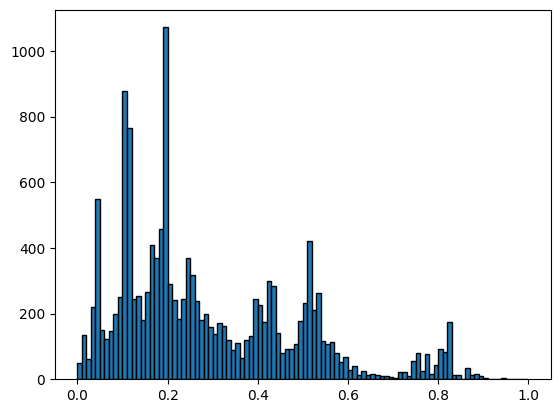

In [ ]:
plt.hist(risk, bins=100, edgecolor='black')
plt.show()

In [ ]:
risk_pred = final_model.predict(x_test1)

In [ ]:
print(classification_report(y_true=y_test1, y_pred=risk_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84     10581
           1       0.61      0.38      0.47      4319

    accuracy                           0.75     14900
   macro avg       0.70      0.64      0.65     14900
weighted avg       0.73      0.75      0.73     14900



In [ ]:
mask = risk > 0.20

mask = mask.astype('int')

print(mask.sum())

8117


In [ ]:
print(classification_report(y_true=y_test1, y_pred=mask))

              precision    recall  f1-score   support

           0       0.87      0.56      0.68     10581
           1       0.42      0.80      0.55      4319

    accuracy                           0.63     14900
   macro avg       0.65      0.68      0.62     14900
weighted avg       0.74      0.63      0.64     14900



In [ ]:
rf = final_model.calibrated_classifiers_[0].estimator

importances_features1 = pd.Series(data=rf.feature_importances_, index=x_train1.columns)

importances_features1 = importances_features1.sort_values(ascending=False)

In [ ]:
importances_features1.head(10)

maxspeed                         0.215365
lanes                            0.189520
motorway                         0.069520
logradouro_SP 150                0.056170
concessionaria_CART              0.044209
logradouro_SP 270                0.043487
hora                             0.040702
concessionaria_NAO DISPONIVEL    0.032527
logradouro_SP 348                0.029533
concessionaria_AUTOBAN           0.026151
dtype: float64

In [ ]:
severity_pred = severity_model.predict(x_test2)

In [ ]:
mae_error = mean_absolute_error(y_true=y_test2, y_pred=severity_pred)
rmse_error = root_mean_squared_error(y_true=y_test2, y_pred=severity_pred)

In [ ]:
print(mae_error)
print(rmse_error)
print(severity_pred.mean())
print(severity_pred.max())
print(severity_pred.min())

32.299882117858765
64.73867383197104
24.794909918838343
287.95345022745374
1.4655766248619135


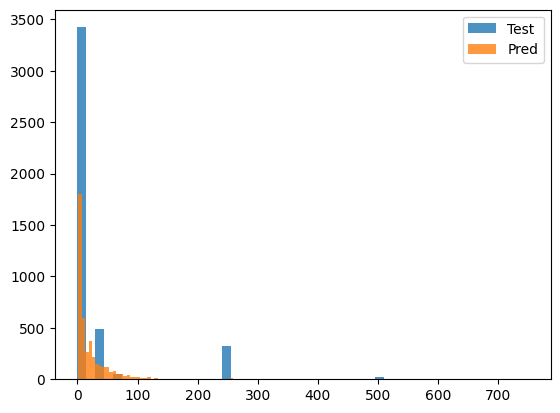

In [ ]:
plt.hist(y_test2, bins=50, alpha=0.8, label='Test')
plt.hist(severity_pred, bins=50, alpha=0.8, label='Pred')

plt.legend()
plt.show()

In [ ]:
importances_features2 = pd.Series(data=severity_model.feature_importances_, index=x_train1.columns)

importances_features2 = importances_features2.sort_values(ascending=False)

In [ ]:
importances_features2.head(10)

concessionaria_ROTA SOROCABANA           0.156925
concessionaria_ECOVIAS RAPOSO-CASTELO    0.155809
hora                                     0.134773
concessionaria_VIAPAULISTA               0.082877
concessionaria_NAO DISPONIVEL            0.063607
mes                                      0.061119
dia_semana                               0.055659
concessionaria_DER                       0.051570
maxspeed                                 0.040879
concessionaria_SPVIAS                    0.027910
dtype: float64

In [ ]:
severity = severity_model.predict(x_test1)

In [ ]:
score = pd.Series(data=risk*severity, index=x_test1.index)

In [ ]:
score.sort_values(ascending=False)

49760    168.813445
84307    168.025696
90560    166.833193
5282     157.962636
87316    151.734208
            ...    
32859      0.000000
50293      0.000000
83671      0.000000
73708      0.000000
39962      0.000000
Length: 14900, dtype: float64

In [ ]:
x_test1.loc[[49760, 84307, 90560, 5282, 87316]]

,hora,mes,dia_semana,feriado,motorway,oneway,lanes,maxspeed,bridge,logradouro_SP 070,...,concessionaria_ECOVIAS,concessionaria_ECOVIAS RAPOSO-CASTELO,concessionaria_EIXOSP - PIPA,concessionaria_ENTREVIAS,concessionaria_INTERVIAS,concessionaria_NAO DISPONIVEL,concessionaria_ROTA SOROCABANA,concessionaria_SPVIAS,concessionaria_VIAOESTE,concessionaria_VIAPAULISTA
49760,1,10,6,0,1,1,3,90,0,0,...,0,1,0,0,0,0,0,0,0,0
84307,1,8,6,0,1,1,3,90,0,0,...,0,1,0,0,0,0,0,0,0,0
90560,4,5,6,0,1,1,3,90,0,0,...,0,1,0,0,0,0,0,0,0,0
5282,7,11,6,0,1,1,3,90,0,0,...,0,1,0,0,0,0,0,0,0,0
87316,5,10,2,0,1,1,3,90,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
if1 = pd.Series(data=importances_features1, index=x_test1.columns)
if2 = pd.Series(data=importances_features2, index=x_test1.columns)

<Axes: >

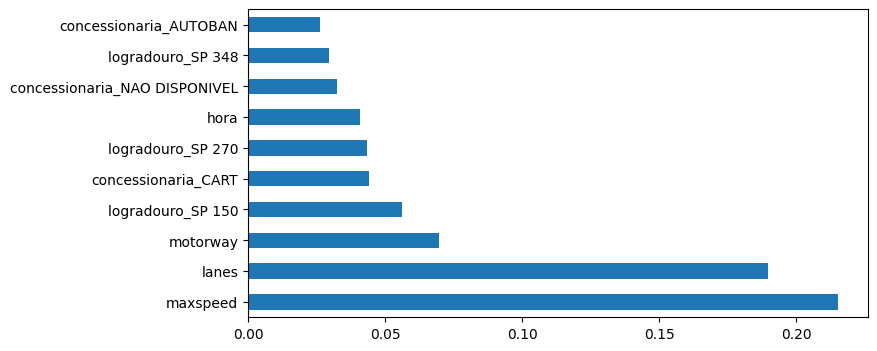

In [ ]:
if1.nlargest(10).plot(kind='barh', figsize=(8, 4))

<Axes: >

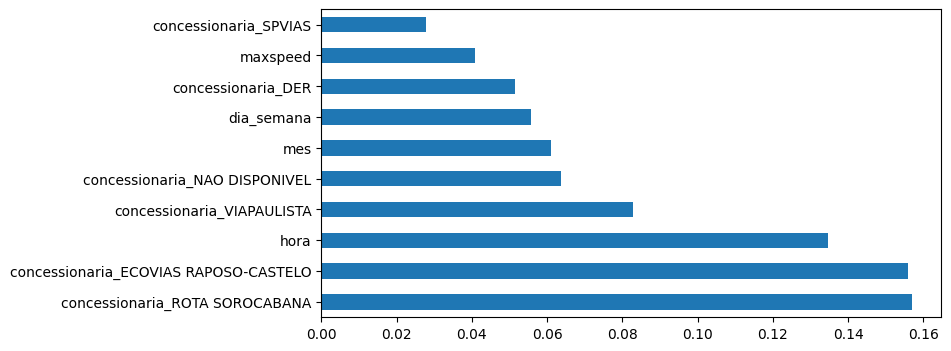

In [ ]:
if2.nlargest(10).plot(kind='bar', figsize=(8, 4))

In [ ]:
#joblib.dump(value=final_model, filename='risk_model.pkl')

['risk_model.pkl']

In [ ]:
#joblib.dump(value=severity_model, filename='severity_model.pkl')

['severity_model.pkl']